## Accessing GBIF data on Azure

This notebook provides an example of accessing Global Biodiversity Information Facility (GBIF) occurrence data from blob storage on Azure.  Periodic snapshots of the data are stored in Parquet format.

This dataset is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in the same region.  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

This dataset is documented at [aka.ms/ai4edata-aster](http://aka.ms/ai4edata-gbif).    

### Environment setup

In [1]:
import dask.dataframe as dd
from adlfs import AzureBlobFileSystem

storage_account_name = 'ai4edataeuwest'
folder_name = 'gbif/occurrence'

### List the data files

GBIF provide an export of occurrence data under the Creative Commons Zero and Creative Commons By-Attribution licenses.  A dataset is uploaded periodically containing georeferenced records available under either license.

We can use `adlfs` to view the available data exports:

In [2]:
fs = AzureBlobFileSystem(account_name=storage_account_name)
export_folders = fs.glob(folder_name + '/20*')
print('Found {} GBIF data exports'.format(len(export_folders)))
for k in range(0,len(export_folders)):
    print(export_folders[k])

Found 1 GBIF data exports
gbif/occurrence/2021-04-13


We can then list the files within one of these exports, in this case the last (most recent) one:

In [3]:
data_path = export_folders[-1]

fs = AzureBlobFileSystem(account_name=storage_account_name)
parquet_files = fs.glob(data_path + '/occurrence.parquet/*')
print('Found {} Parquet files in export {}'.format(len(parquet_files), data_path))
for k in range(0,5):
    print('    ' + parquet_files[k])
print('    …')

Found 901 Parquet files in export gbif/occurrence/2021-04-13
    gbif/occurrence/2021-04-13/occurrence.parquet/000000
    gbif/occurrence/2021-04-13/occurrence.parquet/000001
    gbif/occurrence/2021-04-13/occurrence.parquet/000002
    gbif/occurrence/2021-04-13/occurrence.parquet/000003
    gbif/occurrence/2021-04-13/occurrence.parquet/000004
    …


### Open one data file

The whole occurrence dataset has hundreds of millions of records, split across around 100 Parquet files.  We will open just one.

In [4]:
print(data_path)
df = dd.read_parquet('az://' + parquet_files[0],
                     storage_options={'account_name':storage_account_name}).compute()
print(df.head())

gbif/occurrence/2021-04-13
       gbifid                            datasetkey occurrenceid  \
0  2305838350  ad43e954-dd79-4986-ae34-9ccdbd8bf568     KM953194   
1  2305838837  ad43e954-dd79-4986-ae34-9ccdbd8bf568     KR568679   
2  2305839278  ad43e954-dd79-4986-ae34-9ccdbd8bf568     KR746879   
3  2305839610  ad43e954-dd79-4986-ae34-9ccdbd8bf568     JN257280   
4  2305840564  ad43e954-dd79-4986-ae34-9ccdbd8bf568     MF731456   

          kingdom      phylum    class      order         family       genus  \
0        Animalia  Arthropoda  Insecta    Diptera      Sciaridae        None   
1        Animalia  Arthropoda  Insecta  Hemiptera      Aphididae  Myzocallis   
2        Animalia  Arthropoda  Insecta    Diptera  Cecidomyiidae        None   
3  incertae sedis        None     None       None           None        None   
4        Animalia  Arthropoda  Insecta    Diptera   Chironomidae  Limnophyes   

  species  ...       identifiedby dateidentified    license rightsholder  \
0    No

### Plot data

This is a quick plot of latitude and longitude.  We can see the shapes of continents.

(-90.0, 90.0)

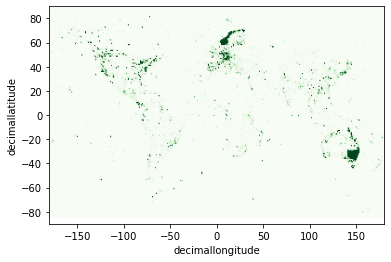

In [5]:
ax = df.plot.hexbin('decimallongitude', 'decimallatitude', gridsize=(360, 180),
                    vmax=100, cmap='Greens', colorbar=False)
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

Another plot shows the month of observation or collection.

(1.0, 12.0)

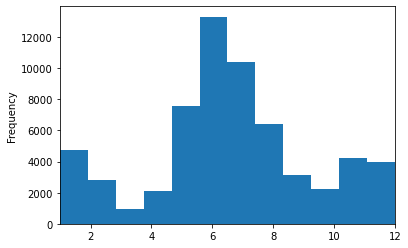

In [6]:
some_plants = df[(df.kingdom == 'Plantae')]
ax = some_plants['month'].plot.hist(x='Month', y='Count', bins=12)

ax.set_xlim(1, 12)

### Citation

It's good practise to cite the data using a DOI (Digital Object Identifier), see GBIF's [Citation Guidelines](https://www.gbif.org/citation-guidelines).

GBIF have a service to create a DOI covering a subset of a cloud dataset.  We need to know the DOI of the cloud dataset, and the number of occurrences we used from each contributing dataset.

In [8]:
print(fs.cat(data_path + '/citation.txt').decode("unicode_escape"))

# This is the usage of the month graph, which only used plants:
some_plants.groupby(by='datasetkey')['gbifid'].count().reset_index(name='count').sort_values(['count'], ascending=False)

GBIF Occurrence Data https://doi.org/10.15468/dl.79tfrn

For citation guidelines, including how to create a DOI for a subset of this dataset, please visit https://www.gbif.org/citation-guidelines#derivedDatasets



,datasetkey,count
3,ad43e954-dd79-4986-ae34-9ccdbd8bf568,33112
7,b124e1e0-4755-430f-9eab-894f25a9b59c,24432
9,be9a09a9-7eb8-4f74-b4a7-e4247c580ee9,7363
12,c1fc2df7-223b-4472-8998-70afb3b749ab,1898
0,a8f27b2e-67a9-43cb-ad18-df43e0152c33,1731
1,ac103da8-23c3-4d6e-891d-266923365893,463
14,c28aed67-1d46-471c-bad1-e875d5515b59,405
4,ad831fd0-4047-41ce-a7b0-568259f6a247,263
11,c031f445-f0b2-4ad4-891e-45bf11730243,188
5,ae379339-581e-4126-9fb1-ea1c1fc91412,150
